<a href="https://colab.research.google.com/github/aimllearning/CapstoneProject/blob/master/CapstoneProject_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Capstone Project Computer Vision**

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

#install pydicom
!pip install pydicom
#import pydicom
import pydicom


Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Set Image Extraction Path

import os
#%cd '../../'
%cd 'drive/My Drive/Colab Notebooks'

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks'
/content/drive/My Drive/Colab Notebooks


In [0]:
def purgedir(parent):
    for root, dirs, files in os.walk(parent):                                      
        for item in files:
            # Delete subordinate files                                                 
            filespec = os.path.join(root, item)
            os.unlink(filespec)
        for item in dirs:
            # Recursively perform this operation for subordinate directories   
            purgedir(os.path.join(root, item))

In [0]:
def are_DCM_Images_Downloaded(dir_name):
  if os.path.exists(dir_name) and os.path.isdir(dir_name):
    if not os.listdir(dir_name):
       return False
    else:    
       return True
    return False

In [0]:
#extract the data
#%cd 'drive/My Drive/Colab Notebooks/Data/DCM'

purgedir('Data/DCM_Test_Images/')
purgedir('Data/DCM_Train_Images/')

from zipfile import ZipFile
testImagesPath = 'Data/stage_2_test_images.zip'
trainImagesPath = 'Data/stage_2_train_images.zip'
#extract test images
with ZipFile(testImagesPath, 'r') as z:
  if are_DCM_Images_Downloaded('Data/DCM_Test_Images/') == False:
     z.extractall('Data/DCM_Test_Images/')
#extract train images
with ZipFile(trainImagesPath, 'r') as z:
  if are_DCM_Images_Downloaded('Data/DCM_Train_Images/') == False:
    z.extractall('Data/DCM_Train_Images/')

In [0]:
#do listing of the data which we are using for input
print(os.listdir("Data"))

['stage_2_detailed_class_info (1).csv', 'stage_2_detailed_class_info.csv', 'stage_2_train_labels.csv', 'stage_2_train_labels.csv.zip', 'stage_2_sample_submission.csv', 'GCP Credits Request Link - RSNA.txt', 'stage_2_test_images.zip', 'stage_2_train_images.zip', 'DCM_Test_Images', 'DCM_Train_Images']


Let's explore the target classes

In [0]:
patient_classes = pd.read_csv('Data/stage_2_detailed_class_info.csv')
patient_classes.head(10)

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity

Number of total target classes and their names

In [0]:
print("Number of classes in the dataset :: %i" %  len(patient_classes["class"].unique()))
print("Classes' names are :: %s" % patient_classes["class"].unique())

Number of classes in the dataset :: 3
Classes' names are :: ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


Checking the skewness of the data in each data class

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


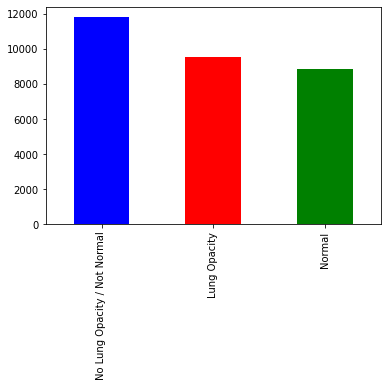

In [0]:
class_count = patient_classes['class'].value_counts()
class_count.plot(kind='bar',color= list('brg'))
print(class_count)

From above we observe that the data is not skewed. Let's proceed with the further

Now let's have a look on our train_labels data

In [0]:
train_labels = pd.read_csv('Data/stage_2_train_labels.csv')
print(train_labels.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


From the above example we see that for every label we have a patient ID, and bounding boxes coordinates which are nulls for class 0 and have values for class 1

We can proceed to explore the images and their meta data informaion. Tne images are stored in DICOM format which stores the meta data about each image in the dataset. 

We can explore the meta data information stored for images.

In [0]:
dcm_file = 'Data/DCM_Train_Images/%s.dcm' % train_labels.patientId.tolist()[0]
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data) 

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

we can store all distinct IDs in the dataframe for later use

In [0]:
patientIds = train_labels.drop_duplicates('patientId', keep = 'first').patientId.tolist()

We will now extract the PatientAge and PatientSex fields in the DICOM description for every destince ID in a seperate array for each one and then convert this to a dataframe to be able to use it later.

In [0]:
Sex = []
Age = []
for patientId in patientIds:
    dcm_file = 'Data/DCM_Train_Images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    Sex.append(dcm_data.PatientSex)
    Age.append(int(dcm_data.PatientAge))

##PreProcessing and little more EDA


First we need to find the datatypes of the columns which we are saving in a dataframe

In [0]:
patientInfo = pd.DataFrame({'patientId': patientIds, 'patientSex': Sex, 'patientAge': Age})
patientInfo.dtypes

patientId     object
patientSex    object
patientAge     int64
dtype: object

Let's now explore the data we collected in the dataframe and search for missing values.

In [0]:
patientAge_count = patientInfo['patientAge'].value_counts().sum()
patientSex_count = patientInfo['patientSex'].value_counts().sum()
patient_count = patientInfo['patientId'].value_counts().sum()

print("total number of patientId :: %i" % patient_count )
print("Total number of patients with Non null patientSex :: %i " % patientSex_count )
print("Total number of patients with Non null patientAge :: %i " %  patientAge_count )
print("Number of missing values to be imputed for the first field :: %i " % (patient_count - patientSex_count) )
print("Number of missing values to be imputed for the second field :: %i " % (patient_count - patientAge_count) )

total number of patientId :: 26684
Total number of patients with Non null patientSex :: 26684 
Total number of patients with Non null patientAge :: 26684 
Number of missing values to be imputed for the first field :: 0 
Number of missing values to be imputed for the second field :: 0 


In [0]:
patientInfo = patientInfo.set_index('patientId').join(train_labels.set_index('patientId'))[['patientSex', 'patientAge', 'Target']]
patientInfo.reset_index(inplace=True)
patientInfo.head()

patientId patientSex  patientAge  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6          F          51       0
1  000924cf-0f8d-42bd-9158-1af53881a557          F          19       0
2  000db696-cf54-4385-b10b-6b16fbb3f985          F          25       1
3  000db696-cf54-4385-b10b-6b16fbb3f985          F          25       1
4  000fe35a-2649-43d4-b027-e67796d412e0          M          40       1

In [0]:
patientInfo.describe()

patientAge        Target
count  30227.000000  30227.000000
mean      46.797764      0.316108
std       16.892940      0.464963
min        1.000000      0.000000
25%       34.000000      0.000000
50%       49.000000      0.000000
75%       59.000000      1.000000
max      155.000000      1.000000

Exploring Age Feature

We will explore the distinct age values in the dataset, Age greater than 90 years and also the frequency for each value using histgrams. Note: the oldest person on earth is 122 years old so any value more than this is probably an outlier.

In [0]:
#Eploring Age attribute

patientInfo['patientAge'].unique()

array([ 51,  19,  25,  40,  57,  56,  76,  31,  54,  28,  63,  48,  32,
        26,  22,  12,  78,  75,  23,  59,  49,   6,  70,  58,  36,  73,
        43,  60,  21,  72,  52,  55,  53,  16,  71,  77,  50,  39,  69,
        38,  47,  67,  44,  14,  68,  42,  41,  62,  15,  29,   2,  13,
        34,  61,  35,  66,  45,  74,  30,   7,  46,   3,  37,  85,  20,
        27,  64,  17,  33,  24,  65,  18,   9,  87,  10,  86,  79,  83,
        81,  11,  80,   8,   4,  82,  91,   5,  84,  90,  88,  89, 148,
         1,  92, 151, 153, 150, 155])

In [0]:
patientInfo['patientAge'].hist()

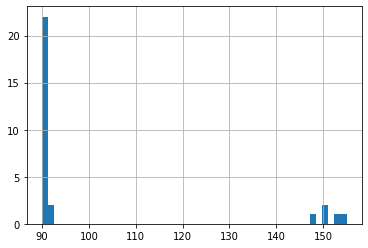

In [0]:
patientInfo[patientInfo['patientAge']>=90]['patientAge'].hist(bins=50)

In [0]:
patientInfo[patientInfo['patientAge']>=85]['patientAge'].value_counts()

86     25
87     20
90     19
85     16
88     12
89      8
91      3
92      2
155     1
153     1
151     1
150     1
148     1
Name: patientAge, dtype: int64

We will explore images from the dataset based on different age groups to see if there is a significant difference in the images to decide if we need further processing.

In [0]:
#exploring gender

patientInfo['patientSex'].unique()


array(['F', 'M'], dtype=object)

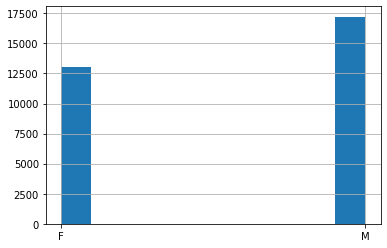

In [0]:
patientInfo['patientSex'].hist()

###*Exploring* Images¶

In [0]:
def draw_img(patient_id, title=None):
    dcm_file = 'Data/DCM_Train_Images/%s.dcm' % patient_id
    dcm_data = pydicom.read_file(dcm_file)
    plt.imshow(dcm_data.pixel_array)
    if title is not None:
        plt.title(title)

In [0]:
patients_greater_100 = patientInfo[patientInfo['patientAge']>=100]
patients_less_5 = patientInfo[patientInfo['patientAge']<=5]
patients_mid_age = patientInfo[(patientInfo['patientAge']>=30) & (patientInfo['patientAge']<= 50)]

In [0]:
def draw_grid(arr_patients, rows=5, columns=4, titles=None, figsize=(15, 15)):
    fig=plt.figure(figsize=figsize)
    for i in range(1, columns*rows + 1):
        if(i <= len(arr_patients)):
            fig.add_subplot(rows, columns, i)
            if titles is None:
                    draw_img(arr_patients[i - 1])
            else:
                    draw_img(arr_patients[i - 1], title=titles[i - 1])
    plt.show()

In [0]:
draw_grid(patients_mid_age['patientId'].tolist())

In [0]:
draw_grid(patients_greater_100['patientId'].tolist(), 2, 2)

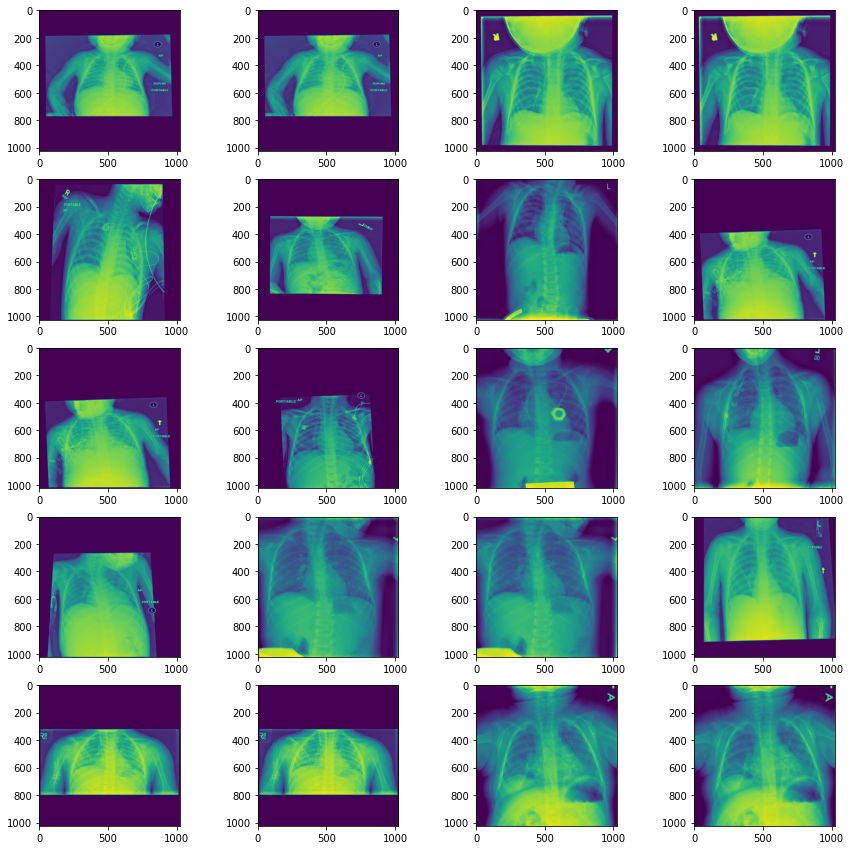

In [0]:
draw_grid(patients_less_5['patientId'].tolist())

In [0]:
patientInfo['age_category'] = (patientInfo['patientAge'] // 10) * 10

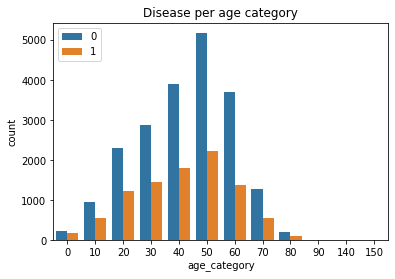

In [0]:
ax = sns.countplot(x="age_category", hue="Target", data=patientInfo)
ax.set_title('Disease per age category')
ax.legend(title='Disease')
ax.legend()

###Explore Gender

We will explore the images based on the ggender of the patient. First we need to see if the number of patients is the same for males and females.

In [0]:
#display the count of each gender
patientInfo['patientSex'].value_counts()

M    17216
F    13011
Name: patientSex, dtype: int64

Now we will try to see is there is a segnificant difference between the radiation images of males and females.

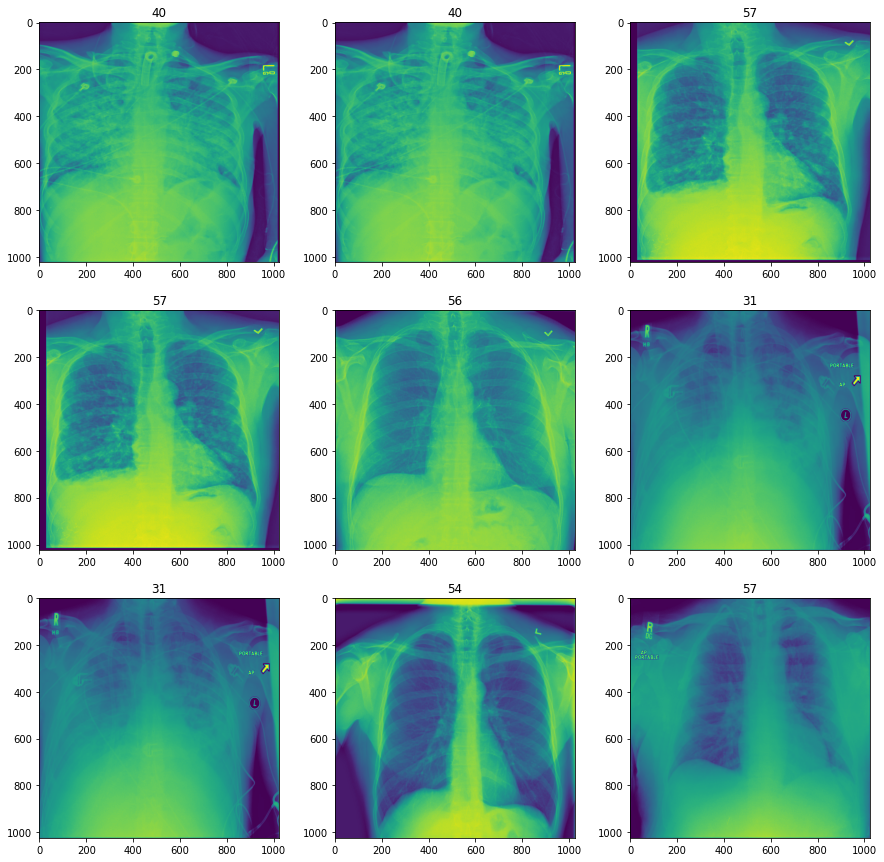

In [0]:
draw_grid(patientInfo[patientInfo['patientSex'] == 'M']['patientId'].tolist(), 3, 3, 
          titles=patientInfo[patientInfo['patientSex'] == 'M']['patientAge'].tolist(), figsize=(15, 15))



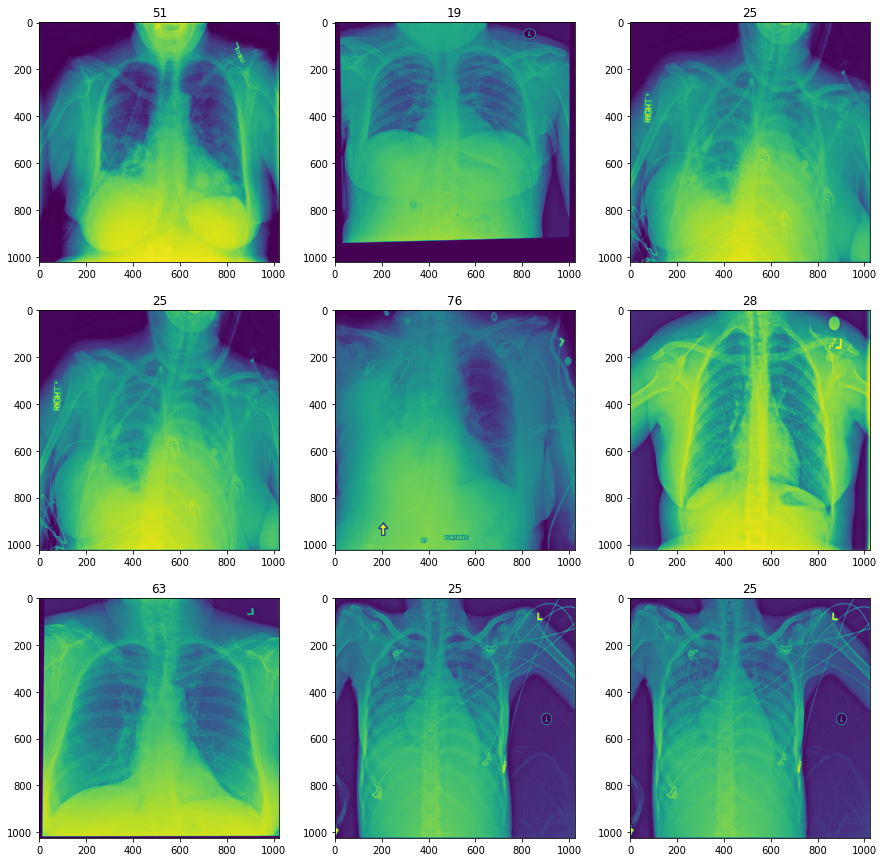

In [0]:
draw_grid(patientInfo[patientInfo['patientSex'] == 'F']['patientId'].tolist(), 3, 3, 
          titles=patientInfo[patientInfo['patientSex'] == 'F']['patientAge'].tolist(), figsize=(15, 15))

There is not visible difference in the images on the basis of gender

We can now visualise the disease in each gender

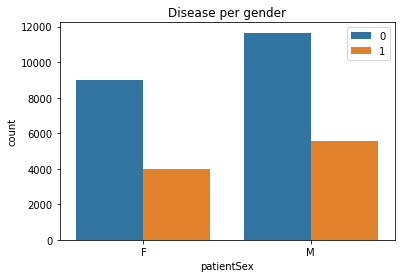

In [0]:
ax = sns.countplot(x="patientSex", hue="Target", data=patientInfo)
ax.set_title('Disease per gender')
ax.legend(title='Disease')
ax.legend()



```
# This is formatted as code
```

###Age and Gender Exploration


We will explore the age, gender and also the target classes. We will discover the data representation using histograms to see how the data looks like.

In [0]:
z = {'F': 1, 'M': 0}
patientInfo['Sex'] = patientInfo['patientSex'].map(z)

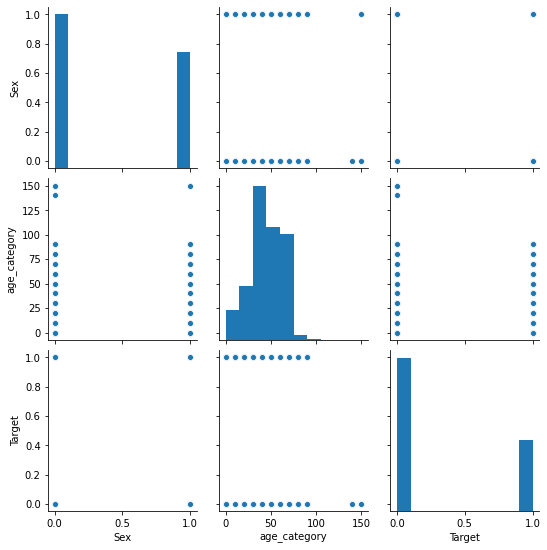

In [0]:
sns.pairplot(patientInfo[['Sex', 'age_category', 'Target']]);

Correlation between features and target variable

In [0]:
corr = patientInfo.corr()
corr

patientAge    Target  age_category       Sex
patientAge      1.000000 -0.056878      0.985862  0.009842
Target         -0.056878  1.000000     -0.055807 -0.016940
age_category    0.985862 -0.055807      1.000000  0.009361
Sex             0.009842 -0.016940      0.009361  1.000000

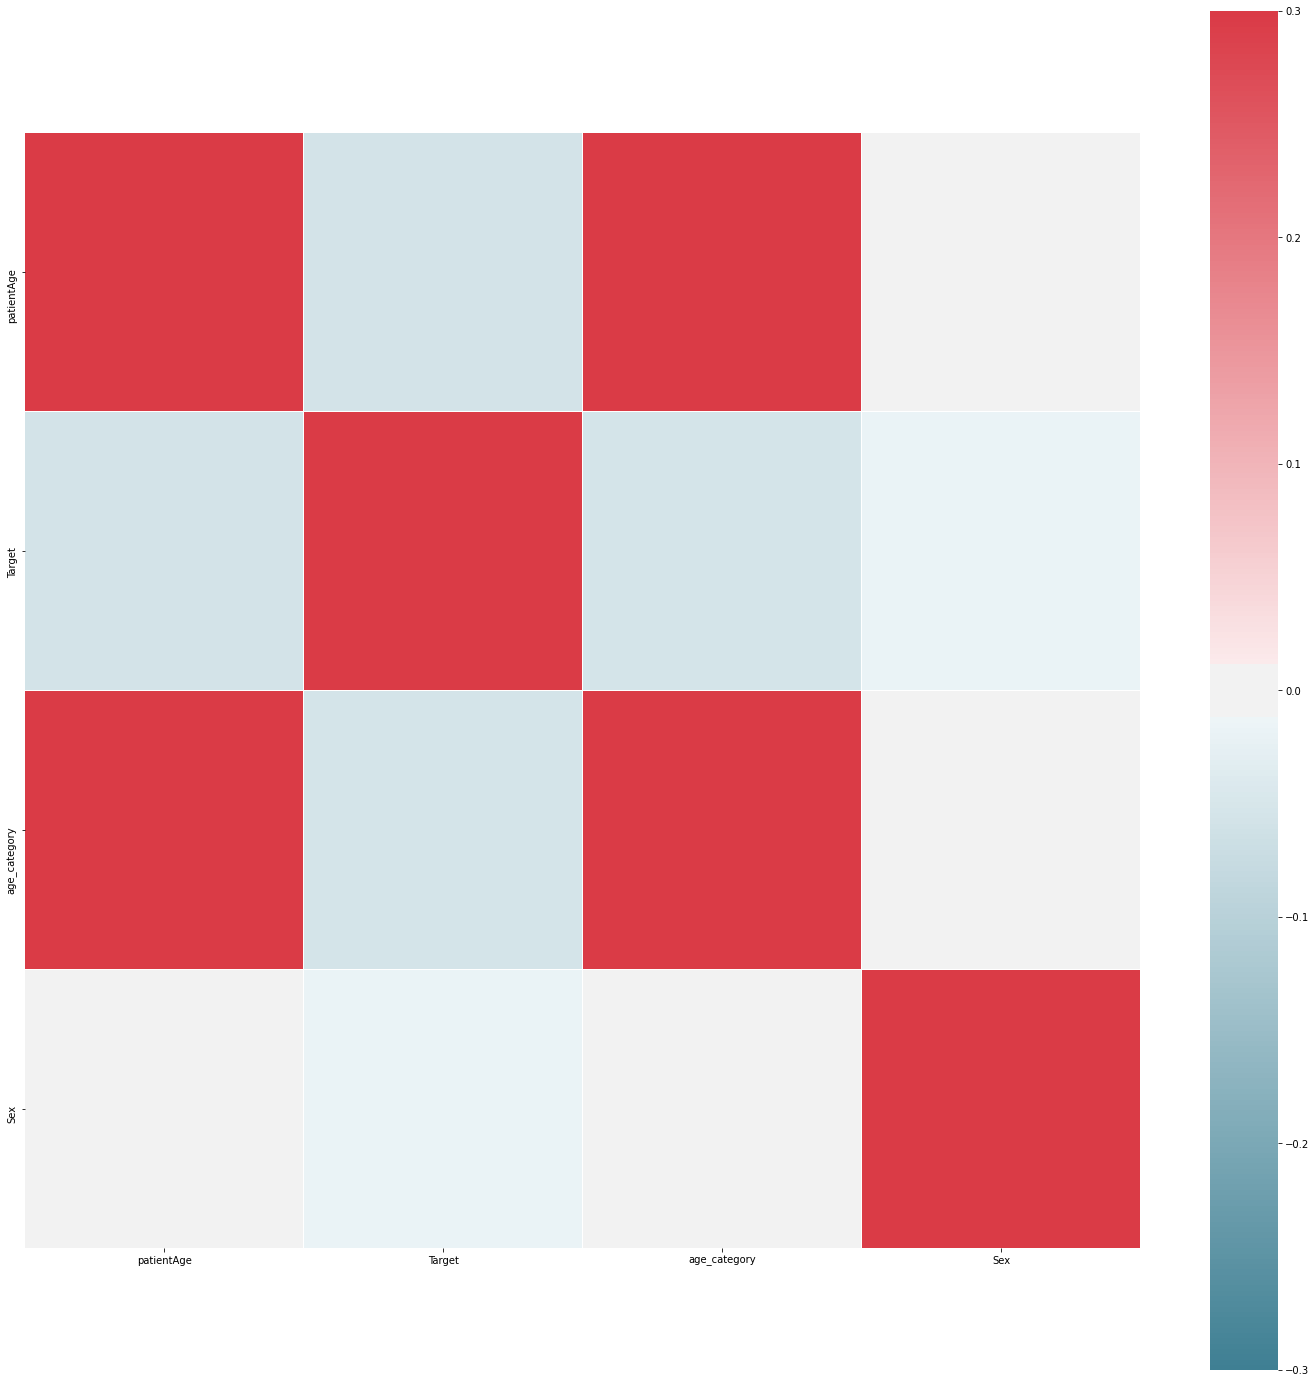

In [0]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax= .3,vmin = - 0.3, center=0,
            square=True, linewidths=.5)



We also have to check if any label that is of the +ve class has Nulls in the bounding boxex data. Since only bounding boxes in the 0 class can have nulls since we will not draw anything.


In [0]:
print("The number instances for the 0 class:: %i and for the 1 class = %i " % (train_labels.Target.value_counts()[0], train_labels.Target.value_counts()[1]) )


The number instances for the 0 class:: 20672 and for the 1 class = 9555 


In [0]:
train_ones = train_labels[train_labels.Target == 1]
train_ones.head()

patientId      x      y  width  height  Target
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1

In [0]:
print("The number of NaN values for bounding box dimentions columns for class 1 data = %s " % train_ones.isna().sum() )

The number of NaN values for bounding box dimentions columns for class 1 data = patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64 


###Drawing bounding boxes on images

In [0]:


train_labels.Target.value_counts()



0    20672
1     9555
Name: Target, dtype: int64

In [0]:
train_labels.iloc[110]

patientId    02e93c9a-c063-4bf2-9fa1-cb26692d58f8
x                                             185
y                                             232
width                                         122
height                                        284
Target                                          1
Name: 110, dtype: object

In [0]:
print('all images:', train_labels.shape[0])
print('unique images:', np.unique(train_labels.patientId.tolist()).shape[0])

all images: 30227
unique images: 26684


In [0]:
def draw_mult_rects(patientIds, rows=3, cols=3, figsize=(15, 15)):
    
    fig=plt.figure(figsize=figsize)
    
    for i in range(1, len(patientIds)+1):
        fig.add_subplot(rows, cols, i)
        records = train_labels[train_labels.patientId == patientIds[i-1]]
        class_label = patient_classes[patient_classes.patientId == patientIds[i-1]]['class'].tolist()[0]
        dcm_file = 'Data/DCM_Train_Images/%s.dcm' % patientIds[i-1]
        dcm_data = pydicom.read_file(dcm_file)
        plt.imshow(dcm_data.pixel_array)
        plt.title(class_label)
        for j in range(records.shape[0]):
            record = records.iloc[j]                
            x = record.x
            y = record.y
            width = record.width
            height = record.height
            if x is not None:
                rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')
                plt.gca().add_patch(rect)
    plt.show()

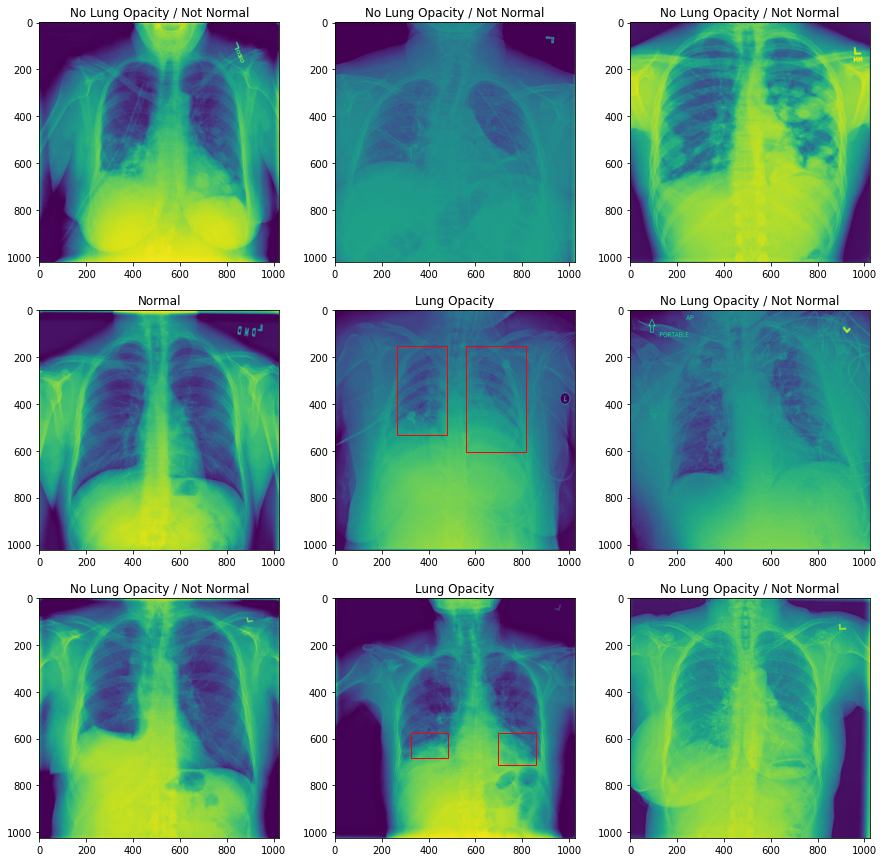

In [0]:
draw_mult_rects(train_labels.patientId.unique()[:9])

###Clustering

We will try to cluster images based on the differences in the features for each patient and examine the output histograms and draw an image for each cluster . We will explore the hestograms of each clustering procedure when changing the number of centroids of the clustering algorithm.

In [0]:
patientId = patientInfo.patientId
tmp_cluster = patientInfo.drop(['patientId', "Target", 'patientSex', 'age_category'], axis = 1)
tmp_cluster['patientAge'].max()

155

In [0]:
from sklearn.cluster import KMeans

def kmeans(n, tmp_cluster) :
    cluster = KMeans(n_clusters=n, max_iter=300, tol=0.0001, verbose=0, random_state = 0, n_jobs=-1).fit(tmp_cluster)
    return cluster.labels_

Plotting the histogram of clustered data and also viewing an image from each cluster to see what we can be gathered in each cluster.

In [0]:
import matplotlib.pyplot as plt
tmp_cluster_Id = pd.DataFrame()
rows = 0
for i in range(2,10):
    columns = 3
    tmp_cluster["clusters"] = kmeans(i, tmp_cluster)
    n, bins, patches = plt.hist(tmp_cluster["clusters"], facecolor='b')
    tmp_cluster_Id = tmp_cluster.copy()
    tmp_cluster_Id["patientId"] = patientId
    pics = ((tmp_cluster_Id.drop_duplicates('clusters', keep = 'first'))['patientId']).tolist()
    
    if( len( pics ) >= 3) :
        rows = (((len(pics) - 3) / 3) + (len(pics) - 3) % 3) + 1
    else : 
        columns = 2
        rows = 1
    draw_grid(pics, columns = columns, rows = int(rows) )
    plt.show()

###Data Augmentation¶


Here we will perform a very simple data augmentation. We will crop the edges of the images since we didn't need it. When trying this with our model it had significant effect on decreasing the variance.

In [0]:
import cv2

def remove_borders(img_data, threshold = 10):
    img_data = img_data[:, np.max(img_data, axis=0) > threshold]
    img_data = img_data[np.max(img_data, axis=1) > threshold]
    img_data = cv2.resize(img_data, (1024, 1024))
    return img_data

Now we will see how the images look like after removing the boarders. I will show the same images as the above images to be able do see the differences.

In [0]:
def read_one_img(patientId):
    dcm_file = 'Data/DCM_Train_Images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    img = dcm_data.pixel_array
    img = remove_borders(img)
    img = cv2.resize(img, (224, 224))
    return img

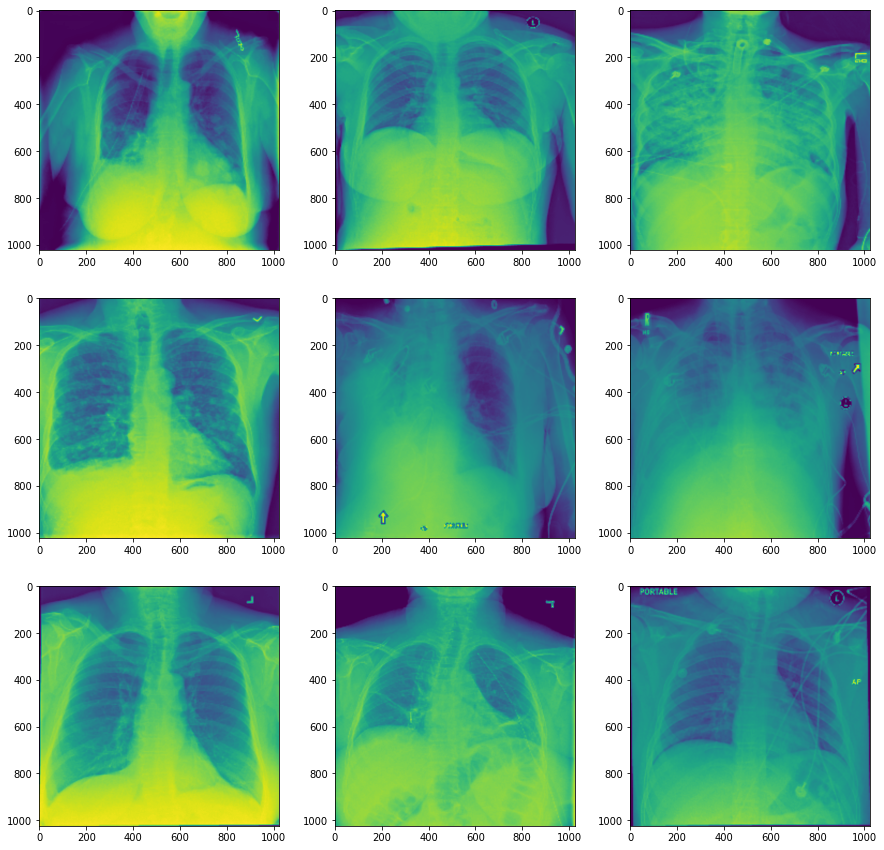

In [0]:
figure=plt.figure(figsize=(15,15))

for (i, j) in enumerate(pics) :
    image = read_one_img(j)
    image_pixels = remove_borders(image)
    figure.add_subplot(3, 3, i+1)
    plt.imshow(image_pixels)
    
plt.show()